In [16]:
import random
from multiprocessing import Pool
from os import makedirs
from os.path import isdir, join
from typing import Dict, List, Any, Tuple
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import einops
from datasets.deap import DEAPDataset

In [2]:
from os.path import isdir
from os import mkdir
images_path = join("images")
if not isdir(images_path):
    makedirs(images_path)
    
scale = 4

In [3]:
dataset = DEAPDataset(path=join("..", "..", "datasets", "deap"), discretize_labels=True, normalize_eegs=True, window_size=1, window_stride=1)

In [6]:
from models.sateer import SATEER
model = SATEER(
        in_channels=len(dataset.electrodes),
        sampling_rate=dataset.sampling_rate,
        labels=dataset.labels,
        labels_classes=dataset.labels_classes,

        users_embeddings=True,
        num_users=len(dataset.subject_ids),

        mels=16,
        mel_window_size=1,
        mel_window_stride=0.25,

        hidden_size=512,
        num_encoders=4,
        num_decoders=4,
        encoder_only=False,
        num_attention_heads=8,
        positional_embedding_type="sinusoidal",
        max_position_embeddings=2048,
        dropout_p=0.25,
        data_augmentation=False,
    )

In [7]:
dataloader = DataLoader(dataset, batch_size=32, num_workers=4, shuffle=False)

torch.Size([32, 16, 6, 32])


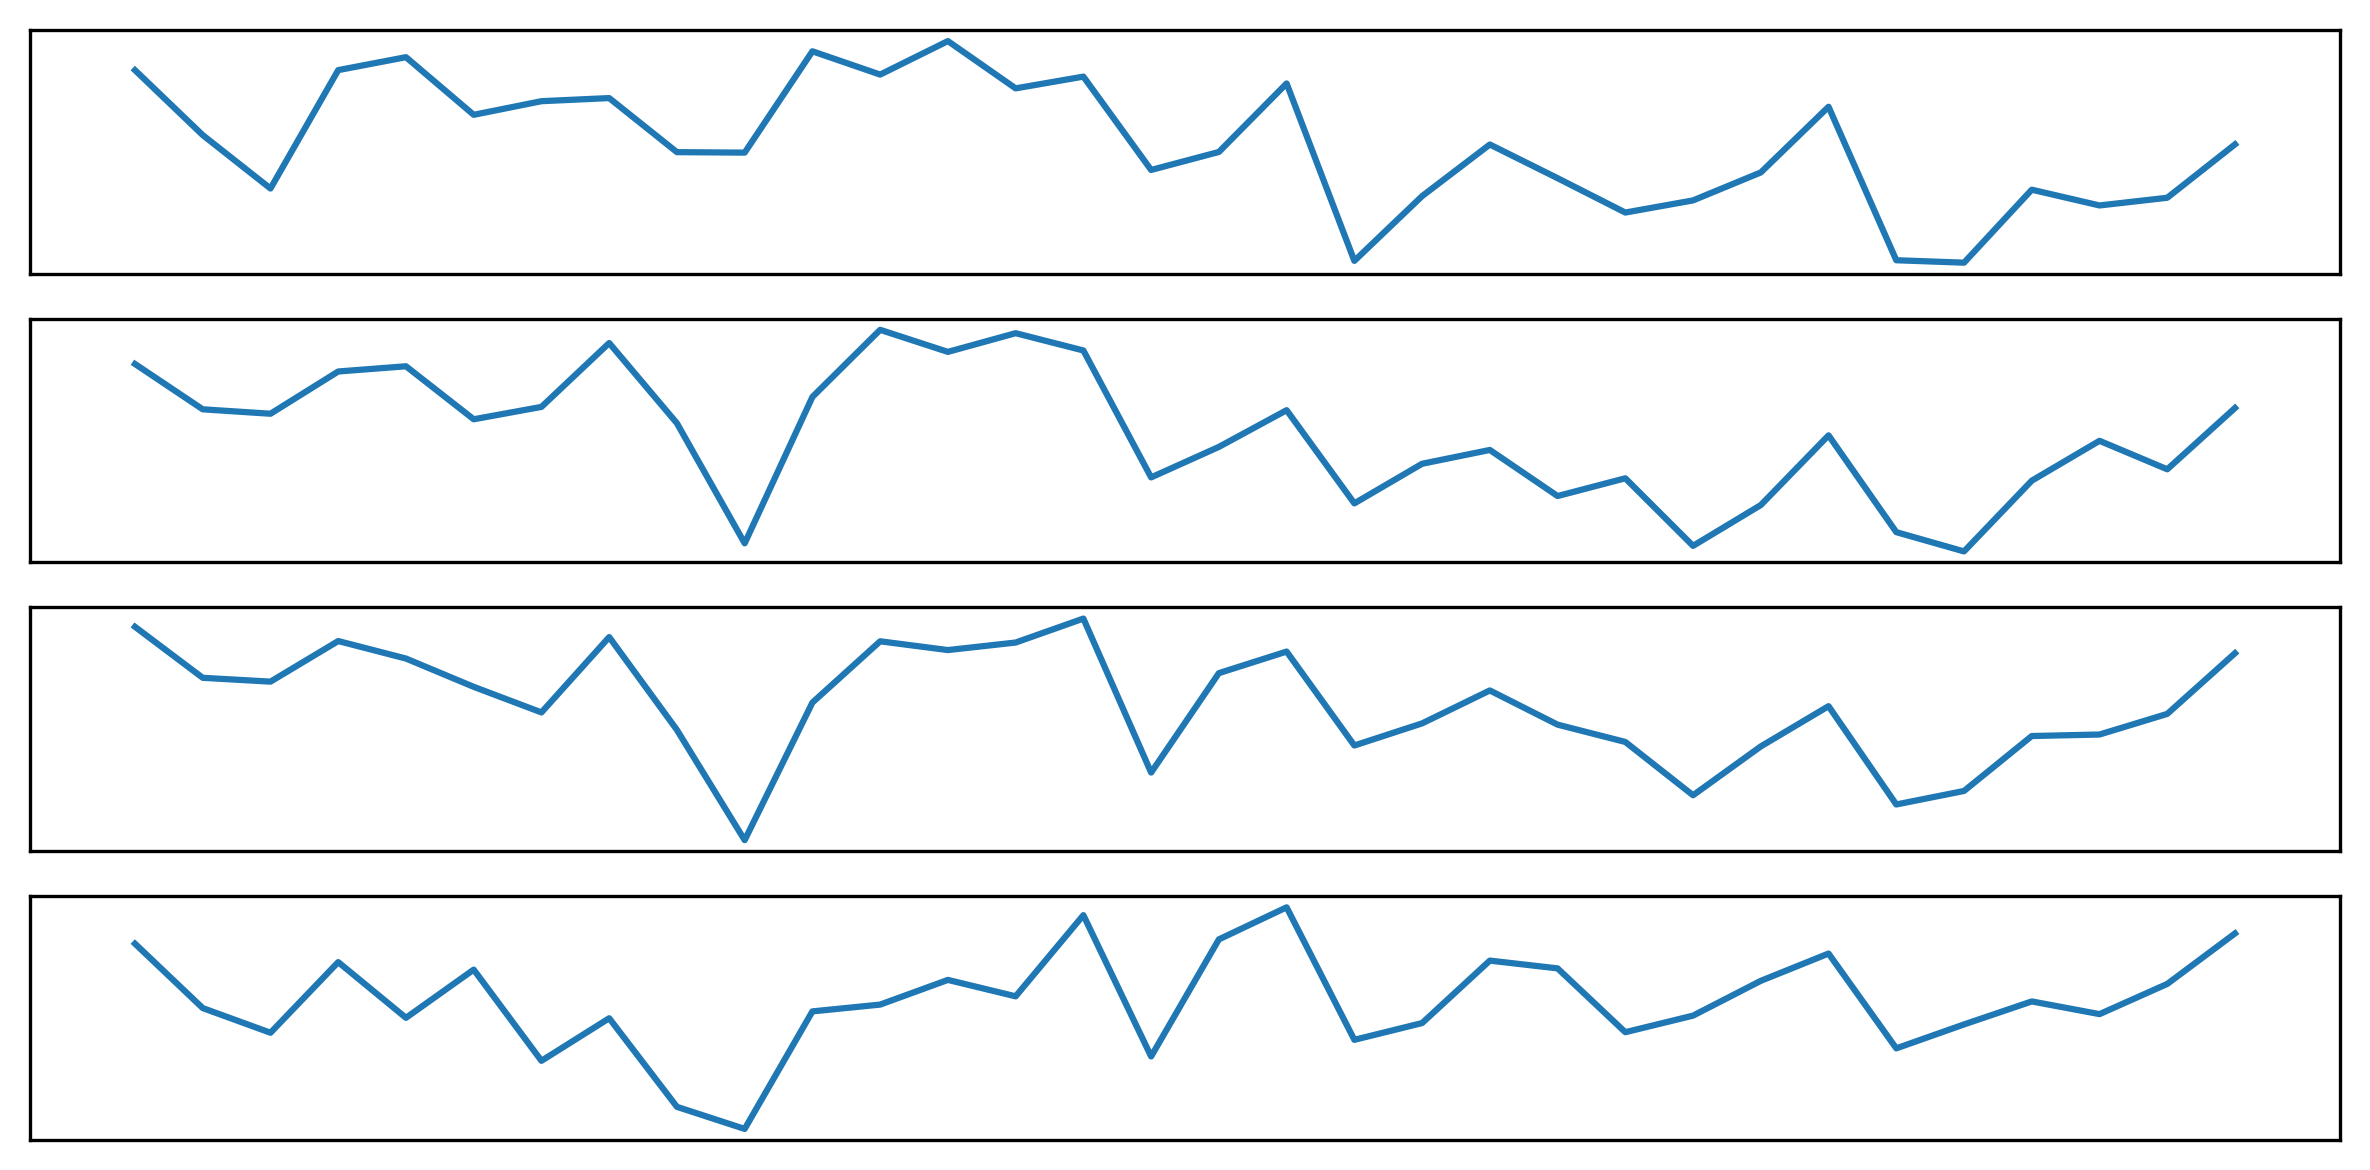

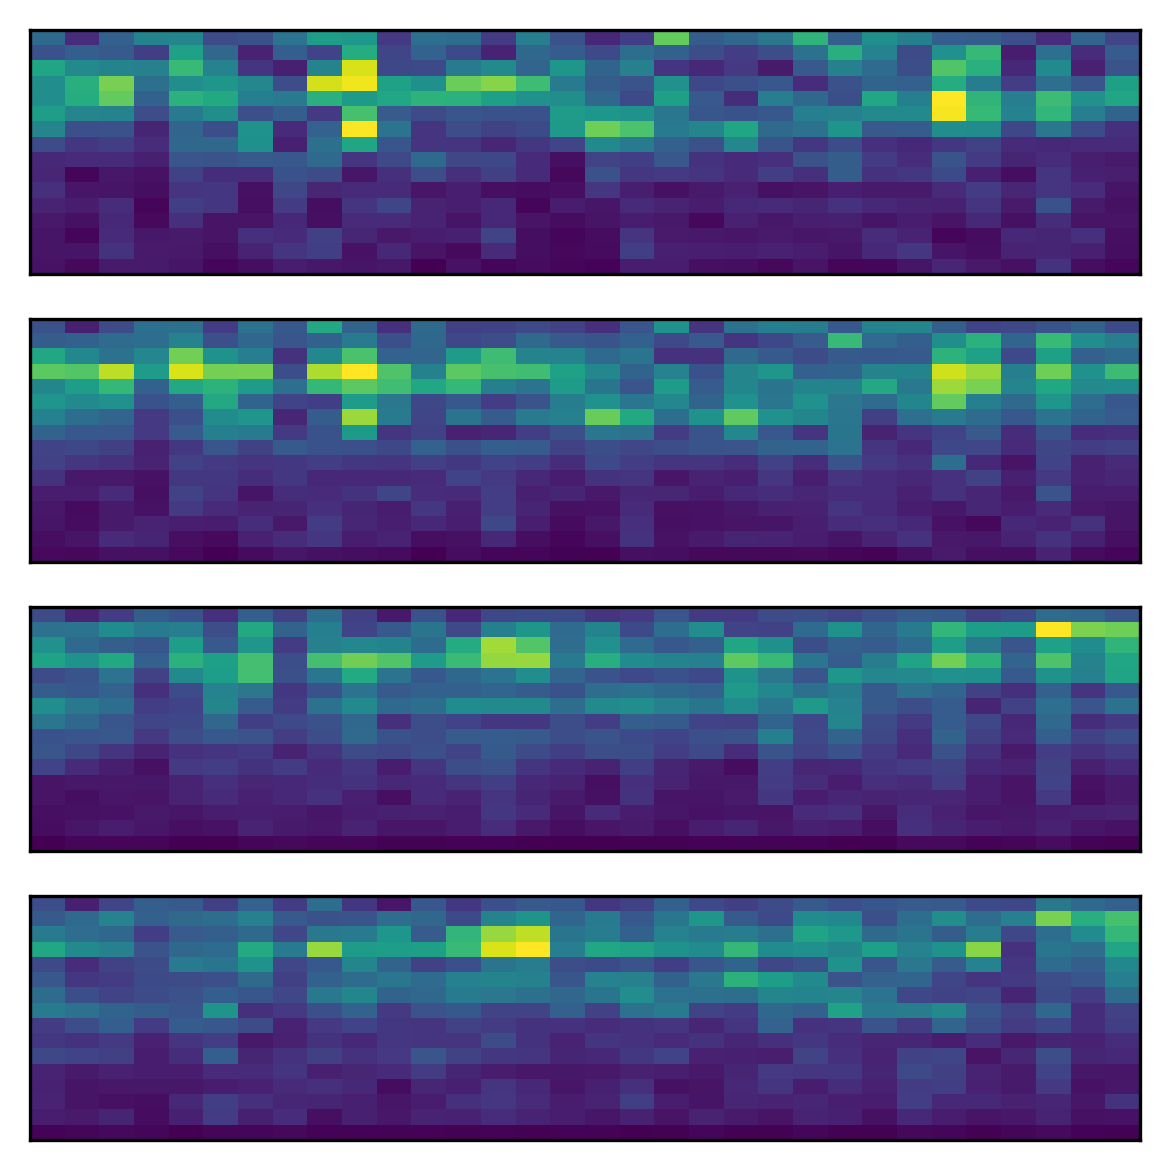

In [27]:
for batch in dataloader:
    spectrogram = model.get_spectrogram(batch["eegs"])
    spectrogram = einops.rearrange(spectrogram, "b t c m -> b m t c")
    outs = model(input_eegs=batch["eegs"], ids=batch["subject_id"])
    
    # plots the waveform
    fig, axs = plt.subplots(4, 1, figsize=(scale * 2, scale), dpi=300, tight_layout=True)
    for i in range(4):
        ax = axs[i]
        ax.plot(batch["eegs"][0][i])
        # remove the ticks and labels
        ax.set_xticks([])
        ax.set_yticks([])
    plt.savefig(join(images_path, "waveform.svg"),  bbox_inches='tight', dpi=300)
    
    # plots the spectrogram
    fig, axs = plt.subplots(4, 1, figsize=(scale, scale), dpi=300, tight_layout=True)
    for i in range(4):
        ax = axs[i]
        ax.imshow(spectrogram[0, :, i, :], aspect='auto')
        # remove the ticks and labels
        ax.set_xticks([])
        ax.set_yticks([])
    plt.savefig(join(images_path, "spectrogram.svg"), bbox_inches='tight', dpi=300)
    print(spectrogram.shape)
    break